In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

Data Extraction (from Alpha Vantage via their API)

I'll also be making use of the American Airlines stock market prices to make my predictions, so I'll set the ticker to "AAL". The specific reason I picked this company over others is that it is bursting with different stock price behaviors over time. This will make the learning more robust and let us test how good the predictions are for a variety of situations.

Since stock prices come in several different flavors, we'll save them accordingly as:

Open: Opening stock price of the day
Close: Closing stock price of the day
High: Highest stock price of the data
Low: Lowest stock price of the day

In [2]:
api_key = 'LOC9YBYQ9T5BT0AL'

# American Airlines stock market prices
ticker = "AAL"

# JSON file with all the stock market data for AAL from the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# If you haven't already saved data,
# grab the data from the url and store date, low, high, volume, close, open values to a Pandas DataFrame
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']), float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save)


Data saved to : stock_market_data-AAL.csv


Data Exploration

In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


Data Vizualization

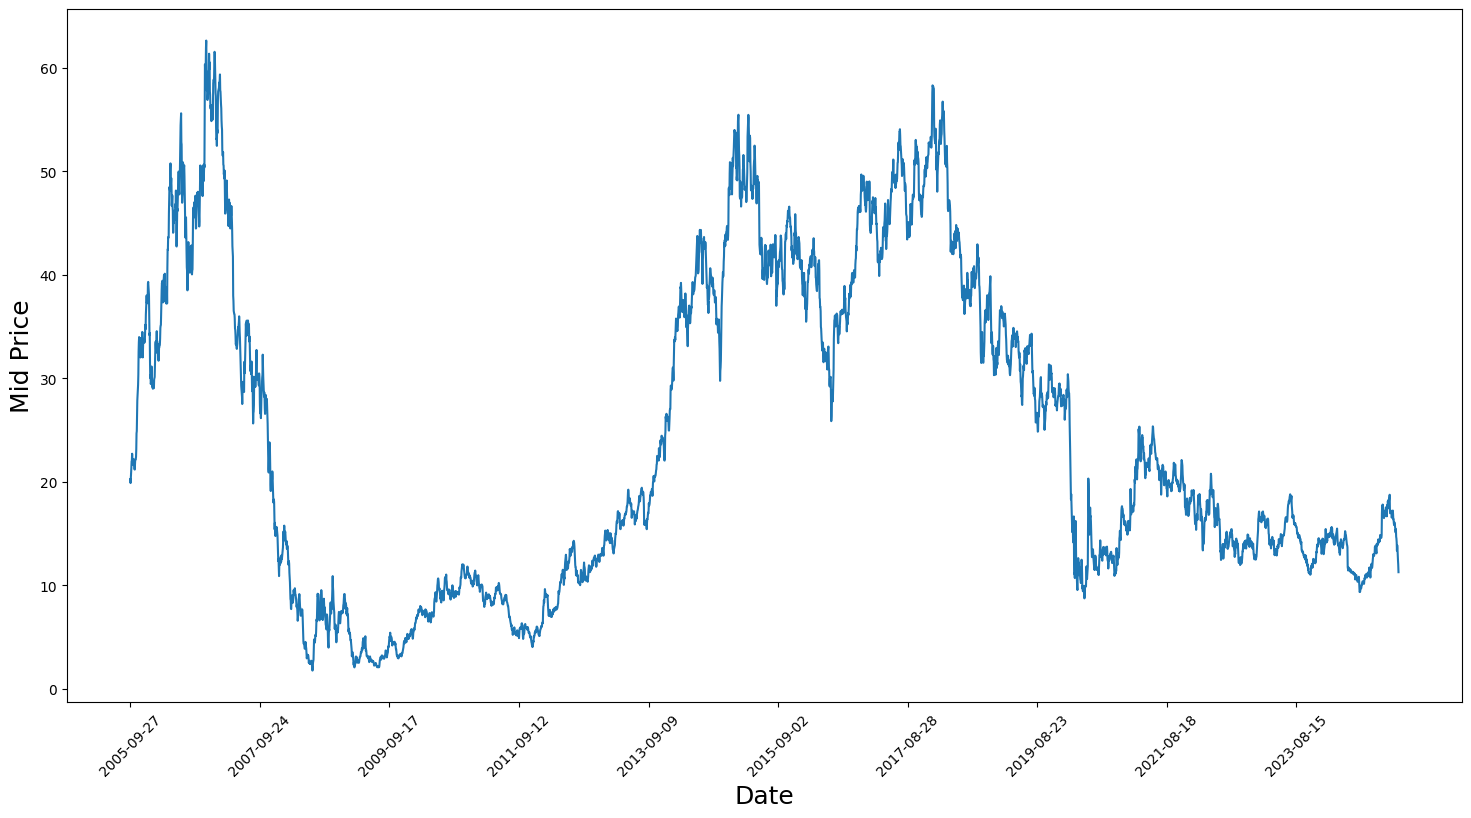

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Splitting the data into training and testing sets

AttributeError: 'Series' object has no attribute 'as_matrix'